# Analysis of chemo diversity on pharmacological and biological activities

The [dataset](results/activities_2022-01-29_16-33-05.csv) is obtained from the Scopus downloader version 2.0 from the [base set](data/activities.csv) of chemical compounds and activities.

**TODO** check:

- <https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe>
- <https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#multiindex-query-syntax>


## Loading data obtained from Scopus

### Boilerplate

Some Python configuration.


In [1]:
from pathlib import Path
from itertools import islice, product
from pprint import pprint
import dataclasses

import pandas as pd
import numpy as np
import numpy.typing as npt
from scipy import linalg
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
import scopus.biblio_extractor as bex

np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 20)
pd.set_option("display.min_rows", 10)

# (11.7, 8.27) = A4 landscape
sns.set_theme(style="dark", palette="muted", font_scale=1.10, rc={"figure.figsize": (16.54, 11.7)})


DATASET_FILENAME = Path("results/pharmaco_chemistry_cross_2022-05-19_17-18-20.csv")
# DATASET_FILENAME = Path("results/activities_2022-01-29_16-33-05.csv")
# DATASET_FILENAME = Path("results/samples_2022-02-09_17-12-54.csv")
print(f"{DATASET_FILENAME.stem = } {DATASET_FILENAME.suffix = }")


DATASET_FILENAME.stem = 'pharmaco_chemistry_cross_2022-05-19_17-18-20' DATASET_FILENAME.suffix = '.csv'


### Loading the CSV file

Now, we load the dataset we'll use in this Notebook. It is generated using [our tool](biblio_extractor.py) in the same repository.
The dataset is a 106 \* 66 matrix, with rows and columns indexed by three levels (using Pandas's `MultiIndex`) as follows:

- level 0 is _class_ (chemical, biological or pharmacological class)
- level 1 is _name_ (compound or activity, a.k.a. keyword)
- level 2 is _kind_ (either _w/o_ for _without_ or _w/_ for _with_)

The matrix is indexed by _two_ disjoint finite sets of keywords:

- **rows**: a set of 53 (chemical) coumpounds = {acridine, triterpene, ...}
- **columns**: a set of 33 (biological, pharmacological) activities = {germination, cytotoxicity, ...}

An example is shown below, restricted to two compounds and two activities.
Note that this is **not** an extract of the whole dataset, the (w/o, w/o) cells being smaller here.

|                   |            |     | germination | germination | cytotoxicity | cytotoxicity |
| ----------------- | ---------- | --- | ----------- | ----------- | ------------ | ------------ |
|                   |            |     | allelopathy | allelopathy | pharmaco     | pharmaco     |
|                   |            |     | w/o         | w/          | w/o          | w/           |
| alkaloid          | acridine   | w/o | 2100        | 32          | 28           | 2104         |
| alkaloid          | acridine   | w/  | 1294        | 11          | 9            | 1296         |
| terpenoid/terpene | triterpene | w/o | 1283        | 11          | 9            | 1285         |
| terpenoid/terpene | triterpene | w/  | 2111        | 32          | 28           | 2115         |

Let $M$ be this matrix, and for each couple of keywords made of a compound and and activity, call $M_{ij} = (c_i, a_j)$, the **ij confusion submatrix**.
Assume that $M_{ij}$ is of the form :
\begin{bmatrix}
FF & FT\\
TF & TT
\end{bmatrix}

Where :

- $FF = (\text{w/o}, \text{w/o})$ is the number of papers that have **neither** the $c_i$ compound **nor** the $a_j$ activity;
- $FT = (\text{w/o}, \text{w/})$ is the number of papers that have the $a_j$ activity but **not** the $c_i$ compound;
- $TF = (\text{w/}, \text{w/o})$ is the number of papers that have the $c_i$ compound but **not** the $a_j$ activity;
- $TT = (\text{w/}, \text{w/})$ is the number of papers that have **both** the $c_i$ compound **and** the $a_j$ activity.

We avoid the open world hypothesis by restricting the analysis to the paper in the domain $D$,
which is the set of papers that have at least one compound and one activity.
By construction:

- $FF + FT$ and $TF + TT$ are constants for each $c_i$ (whatever the choice of $a_j$) and is the total number of papers in $D$ with the $c_i$ comppound;
- $FF + TF$ and $FT + TT$ are constants for each $a_j$ (whatever the choice of $c_i$) and is the total number of papers in $D$ with the $a_j$ activity.
- thus each confusion matrix $M_{ij}$ is such that $FF + FT + TF + TT = |D|$ where $|D|$ is _the total number of paper_ under scrutiny.


In [2]:
dataset, margin_rows, margin_cols = bex.load_results(DATASET_FILENAME)
all_compounds = set(dataset.index.get_level_values(1))
all_activities = set(dataset.columns.get_level_values(1))

display(dataset)


abiotic 
 ... 
 pharmaco 
 toxicity 
 
 
 
 
 
 antioxidant 
 drought 
 metal 
 ... 
 sedative 
 wound 
 toxicity 
 
 
 
 
 
 w/o 
 w/ 
 w/o 
 w/ 
 w/o 
 ... 
 w/ 
 w/o 
 w/ 
 w/o 
 w/ 
 
 
 
 
 alkaloid 
 acridine 
 w/o 
 183327 
 64005 
 246196 
 1136 
 221650 
 ... 
 2503 
 240364 
 6968 
 221076 
 26256 
 
 
 w/ 
 2475 
 275 
 2748 
 2 
 2491 
 ... 
 8 
 2671 
 79 
 2335 
 415 
 
 
 benzylamine 
 w/o 
 185015 
 64207 
 248084 
 1138 
 223450 
 ... 
 2505 
 242195 
 7027 
 222653 
 26569 
 
 
 w/ 
 787 
 73 
 860 
 0 
 691 
 ... 
 6 
 840 
 20 
 758 
 102 
 
 
 colchicine 
 w/o 
 180095 
 64077 
 243038 
 1134 
 218319 
 ... 
 2477 
 237349 
 6823 
 218372 
 25800 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 terpenoid/terpene 
 sesterterpene 
 w/ 
 186 
 7 
 193 
 0 
 193 
 ... 
 1 
 191 
 2 
 181 
 12 
 
 
 tetraterpene/carotenoid/xanthophyll 
 w/o 
 182734 
 56504 
 238462 
 776 
 213902 
 ... 
 2507 
 232291 
 6947 
 213416 
 25822 
 
 
 w/ 
 3068 
 7776 
 10482 
 362 
 10239 
 ... 
 4 
 10744 
 100 
 9995 
 849 
 
 
 triterpene 
 w/o 
 181206 
 63075 
 243146 
 1135 
 218392 
 ... 
 2489 
 237450 
 6831 
 218048 
 26233 
 
 
 w/ 
 4596 
 1205 
 5798 
 3 
 5749 
 ... 
 22 
 5585 
 216 
 5363 
 438 
 
 
 
 106 rows × 66 columns

### Extractiong the "old" "w/, w/" matrix

We can extract the "old" 53\*33 matrix we use in the version version of this software, where we had only the with/with queries.
In our small running example, that would be:

|                   |            | germination | cytotoxicity |
| ----------------- | ---------- | ----------- | ------------ |
|                   |            | allelopathy | pharmaco     |
| alkaloid          | acridine   | 11          | 1296         |
| terpenoid/terpene | triterpene | 32          | 2115         |


In [3]:
with_with_matrix = dataset.xs("w/", level=2).xs("w/", level=2, axis=1)
with_with_matrix

abiotic 
 ... 
 pharmaco 
 toxicity 
 
 
 
 
 antioxidant 
 drought 
 metal 
 salt 
 uv 
 ... 
 obesity 
 rheumatism 
 sedative 
 wound 
 toxicity 
 
 
 
 
 alkaloid 
 acridine 
 275 
 2 
 259 
 163 
 81 
 ... 
 3 
 0 
 8 
 79 
 415 
 
 
 benzylamine 
 73 
 0 
 169 
 82 
 25 
 ... 
 35 
 0 
 6 
 20 
 102 
 
 
 colchicine 
 203 
 4 
 88 
 190 
 21 
 ... 
 180 
 20 
 34 
 224 
 871 
 
 
 cyclopeptide 
 58 
 1 
 169 
 37 
 16 
 ... 
 47 
 7 
 4 
 51 
 177 
 
 
 imidazole 
 1101 
 8 
 2591 
 1207 
 312 
 ... 
 300 
 1 
 491 
 474 
 1796 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 terpenoid/terpene 
 polyterpene 
 0 
 0 
 0 
 0 
 0 
 ... 
 0 
 0 
 0 
 0 
 2 
 
 
 sesquiterpene 
 897 
 20 
 72 
 60 
 42 
 ... 
 52 
 0 
 30 
 135 
 349 
 
 
 sesterterpene 
 7 
 0 
 0 
 3 
 0 
 ... 
 1 
 0 
 1 
 2 
 12 
 
 
 tetraterpene/carotenoid/xanthophyll 
 7776 
 362 
 605 
 527 
 404 
 ... 
 436 
 1 
 4 
 100 
 849 
 
 
 triterpene 
 1205 
 3 
 52 
 60 
 46 
 ... 
 134 
 2 
 22 
 216 
 438 
 
 
 
 53 rows × 33 columns

### Sanity checks

We do some sanity checks explained earlier :

- the name (level 2 of rows/columns) are _unique_
- the sum of each confusion submatrixes is _constant_ and is the total number of papers $|D|$, here 243 964.


In [4]:
# sanity check #1
assert dataset.shape == (2 * len(all_compounds), 2 * len(all_activities))
dataset


# sanity check : group by summing on level 2 on both rows and cols produce a matrix of constants : the number of papers
submatrix_sum = dataset.groupby(level=1).sum().groupby(level=1, axis=1).sum()
number_of_papers = np.unique(submatrix_sum.values)
# if the Scopus collection did not evolve during while querying
assert len(number_of_papers) == 1

number_of_papers = number_of_papers[0]
print(f"The domain contains {number_of_papers} papers")

with_with_total = with_with_matrix.values.sum()
print(
    f"Total number of positive/positive occurrences is {with_with_total} for {number_of_papers} papers (average={with_with_total/number_of_papers})"
)


The domain contains 250082 papers
Total number of positive/positive occurrences is 394120 for 250082 papers (average=1.5759630841084125)


## Analysing data

### Extracting the confusion submatrixes

Lets illustrate the content of this table. The **2 by 2 confusion submatrix** about _acridine_ and _cytotoxicity_ is as follows.


In [5]:
acridine_cytotoxicity_submatrix = dataset.loc[
    (
        "alkaloid",
        "acridine",
    ),
    (
        "pharmaco",
        "cytotoxicity",
    ),
]
print(f"Among {number_of_papers} papers, there are")
for i, j in product(bex.SELECTORS, bex.SELECTORS):
    print(f"- {acridine_cytotoxicity_submatrix.loc[i,j]} papers {i} acridine and {j} cytotoxicity in their keywords")

print("The acridine and cytotoxicity confusion matrix is as follows")
acridine_cytotoxicity_submatrix


Among 250082 papers, there are
- 207150 papers w/o acridine and w/o cytotoxicity in their keywords
- 40182 papers w/o acridine and w/ cytotoxicity in their keywords
- 1423 papers w/ acridine and w/o cytotoxicity in their keywords
- 1327 papers w/ acridine and w/ cytotoxicity in their keywords
The acridine and cytotoxicity confusion matrix is as follows


,w/o,w/
w/o,207150,40182
w/,1423,1327


### Marginal sums

We compute marginal sums on rows and cols by and and compare to those already stored in the results dataset.

In [6]:
margin_cols_manual = dataset.groupby(level=1).sum().drop_duplicates().reset_index(drop=True)
margin_cols_manual.index = pd.MultiIndex.from_tuples([bex.MARGIN_IDX])
assert np.all(margin_cols.values == margin_cols_manual.values)

margin_rows_manual = dataset.groupby(level=1, axis=1).sum().iloc[:, 0]
margin_rows_manual.name = bex.MARGIN_IDX
assert np.all(margin_rows.values == margin_rows_manual.values)


In [7]:
# def intersection_metric(arr):
#     """The trivial one. Just keep the bottom right cell. Amount to compute on "the old matrix" """
#     [FF, FT], [TF, TT] = arr.reshape(2, 2)
#     return TT / (FF + FT + TF + TT)


def tt_projection_metric(arr):
    """The trivial one. Just keep the bottom right cell. Amount to compute on "the old matrix" """
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT


def row_implication_metric(arr):
    """The % of paper that have both keywords among the first one. Values add to 1 row wise"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (TF + TT)


def col_implication_metric(arr):
    """The % of paper that have both keywords among the second one. Values add to 1 col wise"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (FT + TT)


def fowlkes_mallows_metric(arr):
    """Computes the Fowlkes-Mallows index: sqrt(the product of row and col implication)"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / np.sqrt((FT + TT) * (TF + TT))


def accuracy_metric(arr):
    """Computes the accuracy"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (TT + FF) / (FF + FT + TF + TT)


def x_metric(arr):
    """Some another one by our own"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (FF + TT - FT - TF) / (FF + FT + TF + TT)


def fraction_metric(arr):
    """The % of paper that have both keywords among the ones having at least one."""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (FT + TF - TT)


def odds_metric(arr):
    """The odds of havin related keywords."""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (FF + TT) / (FT + TF)


def logit_metric(arr):
    """The log odds of having related keywords."""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return np.log((FF + TT) / (FT + TF))


metrics = [
    tt_projection_metric,
    row_implication_metric,
    col_implication_metric,
    fowlkes_mallows_metric,
    fraction_metric,
    odds_metric,
    # logit_metric,
]


print("An example on the acridine/cytotoxicity submatrix, its score for each metric")
print(acridine_cytotoxicity_submatrix)

for metric in metrics:
    print(f"- {metric.__name__:<22} = {metric(acridine_cytotoxicity_submatrix.values)}")


An example on the acridine/cytotoxicity submatrix, its score for each metric
        w/o     w/
w/o  207150  40182
w/     1423   1327
- tt_projection_metric   = 1327
- row_implication_metric = 0.48254545454545456
- col_implication_metric = 0.031968970584692474
- fowlkes_mallows_metric = 0.12420338740203786
- fraction_metric        = 0.03294602512537862
- odds_metric            = 5.010864078836678


**Remark** we'd love to say that "acridine  _partly implies_ cytotoxicity " ! Among 33 activities, about 48% of papers about acridine are about cytotoxicity !
**Important** look for implication rules ?

### Applying the metrics

First, we have some fun with Numpy

In [8]:
# redimension the values to a 4D array
C, A = len(all_compounds), len(all_activities)
print(C, A)
M_2_2 = np.moveaxis(dataset.values.reshape((C, 2, A, 2)), 1, -2)
# 1D is easier for apply_along_axis
M_4 = M_2_2.reshape((C * A, 4))

print(f"{M_2_2.shape = }")
print(f"{M_4.shape = }")

# M.sum(axis=(2,3)) or similarly
np_nb_paper = np.sum(M_2_2, axis=(2, 3), keepdims=False)
print(f"{np.all(np_nb_paper == number_of_papers) = } (with {number_of_papers = })")


53 33
M_2_2.shape = (53, 33, 2, 2)
M_4.shape = (1749, 4)
np.all(np_nb_paper == number_of_papers) = True (with number_of_papers = 250082)


In [9]:

THRESHOLD = number_of_papers//1000
print(f"{THRESHOLD = }")
mask_ff = (M_4 >= THRESHOLD).all(axis=1)
mask_4 = np.repeat(mask_ff, 4, axis = 0).reshape((C,A,2,2))
mask_CA = np.moveaxis(mask_4,2,1).reshape((C*2, A*2))


THRESHOLD = 250


We obtain the same as submatrix_sum


In [10]:
filtered = dataset
score_df = {}
C2, A2 = len(filtered.index) // 2, len(filtered.columns) // 2
print(C2, A2)
values = np.moveaxis(filtered.values.reshape((C2, 2, A2, 2)), 1, -2).reshape((C2 * A2, 4))
print(values.shape)
# print(values)
# print(pd.MultiIndex.from_tuples(filtered.index.droplevel(2)))

subfiltered = filtered.xs("w/", level=2).xs("w/", level=2, axis=1)

for metric in metrics:
    metric_name = metric.__name__
    matrix = np.apply_along_axis(metric, 1, values).reshape((C2, A2))
    # print(matrix.shape)

    score_df[metric_name] = pd.DataFrame(matrix, index=subfiltered.index, columns=subfiltered.columns)
    # print(score_df)
    filename = Path(f"{DATASET_FILENAME.stem}_{metric_name}{DATASET_FILENAME.suffix}")
    score_df[metric_name].to_csv(Path("results") / filename)


scores_summary_df = pd.DataFrame.from_dict(
    {f_name: [df.values.min(), df.values.mean(), df.values.max(), df.values.std()] for f_name, df in score_df.items()},
    orient="index",
    columns=["min", "mean", "max", "std"],
)


scores_summary_df


53 33
(1749, 4)


,min,mean,max,std
tt_projection_metric,0.000,225.340,28632.000,1114.287
row_implication_metric,0.000,0.038,1.000,0.081
col_implication_metric,0.000,0.022,0.587,0.050
fowlkes_mallows_metric,0.000,0.018,0.506,0.035
fraction_metric,0.000,0.008,0.969,0.036
odds_metric,1.899,171.410,19236.077,877.203


### Correspondance Analysis

Here, we implement Correspondance Analysis from scratch using SVD from from `scipy.linalg`.
We explore the results on all previous metrics.

In [11]:
# sanity checks
def sanity_scores(all_dfs):
    for metric_name, df in all_dfs.items():
        # The input matrix: the dataset after a metric is applied
        M = df.values
        N = np.sum(M)
        # Z is M normalised
        Z = M / N
        print(f"{metric_name} (grand total {N = })")

        R = np.sum(M, axis=1)  # X @ np.ones(X.shape[1])
        C = np.sum(M, axis=0)  # Z @ np.ones(X.shape[0])

        print(f"    {np.sum(R) = :.4f} and {np.sum(C) = :.4f}")

        r = np.sum(Z, axis=1)
        c = np.sum(Z, axis=0)
        # print(f"    {r[:, np.newaxis].shape = } {c[:, np.newaxis].shape = }")
        print(
            f"    {np.sum(r) = :.4f} and {np.sum(c) = :.4f}"
        )  # \n{100*r = } \n{100*c = }


sanity_scores(score_df)

tt_projection_metric (grand total N = 394120)
    np.sum(R) = 394120.0000 and np.sum(C) = 394120.0000
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
row_implication_metric (grand total N = 65.87150025369134)
    np.sum(R) = 65.8715 and np.sum(C) = 65.8715
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
col_implication_metric (grand total N = 38.79114044725165)
    np.sum(R) = 38.7911 and np.sum(C) = 38.7911
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
fowlkes_mallows_metric (grand total N = 31.265245749812784)
    np.sum(R) = 31.2652 and np.sum(C) = 31.2652
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
fraction_metric (grand total N = 14.801357052112335)
    np.sum(R) = 14.8014 and np.sum(C) = 14.8014
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
odds_metric (grand total N = 299795.3491737335)
    np.sum(R) = 299795.3492 and np.sum(C) = 299795.3492
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000


In [12]:
def normalize(df, *, method="laplace"):
    M = df.values
    # normalize by grand total
    Z = M / np.sum(M)
    # margins
    r = np.sum(Z, axis=1)
    c = np.sum(Z, axis=0)
    # Dc = np.diag(c)
    # Dr = np.diag(r)
    # center Z
    Zc = Z - (r[:, np.newaxis] @ (c[:, np.newaxis].T))
    # normalize
    if method == "laplace":
        S = np.diag(r ** (-0.5)) @ Zc @ np.diag(c ** (-0.5))
    elif method == "rows":
        S = np.diag(r ** (-1)) @ Zc
    elif method == "cols":
        S = Zc @ np.diag(c ** (-1))
    else:
        raise ValueError(f"unknown normalization {method = }")

    return S, r, c


for metric_name, matrix in score_df.items():
    S, r, c = normalize(matrix, method="laplace")
    print(f"{metric_name} {S.shape}, margins:")
    # print(S)
    print(f"rows sum is {np.sum(S, axis=1).sum()}\n{np.sum(S, axis=1)}")
    print(f" cols sum is {np.sum(S, axis=0).sum()}\n{np.sum(S, axis=0)}")


tt_projection_metric (53, 33), margins:
rows sum is 0.9823147478634106
[-0.015   0.0228  0.1378  0.086   0.1018  0.076   0.0172  0.025   0.0873
  0.0124  0.022   0.0139  0.1367  0.073   0.0783  0.1278  0.008   0.0384
  0.0287  0.0414  0.0115  0.0508  0.0274  0.0739  0.0323  0.0042 -0.0037
 -0.0384 -0.2402 -0.0013 -0.0249 -0.0138 -0.2175 -0.0643  0.0365 -0.0692
 -0.0818 -0.0345 -0.0177 -0.0075  0.0621  0.0278  0.012   0.107   0.008
  0.0509  0.0955  0.023  -0.0022  0.0942 -0.0056 -0.0372  0.0053]
 cols sum is 0.9823147478634104
[-0.5928  0.1151 -0.1527  0.0858 -0.1028  0.052   0.0119  0.0917  0.0289
  0.0444  0.0327  0.013   0.0449  0.0108 -0.008   0.0167  0.1051 -0.0251
  0.0724 -0.0552  0.157  -0.0854  0.0695  0.1991  0.1947 -0.0293  0.1192
  0.4397  0.0409  0.0076 -0.0053 -0.0154  0.1013]
row_implication_metric (53, 33), margins:
rows sum is 0.015371566649880302
[-0.0662  0.0306  0.0935  0.0909  0.0355  0.0147  0.0659 -0.008   0.0788
  0.0663  0.0019  0.08    0.1121  0.0306  0.0988  

In [13]:
# the number of dimensions we project onto
NAXIS = 2
NEXAMPLES = 10

# TODO use the standard scipy API
@dataclasses.dataclass
class CA:
    rows_coordinates: npt.NDArray
    cols_coordinates: npt.NDArray
    inertias: npt.NDArray


def correspondence_analysis(df) -> CA:

    # normalize
    S, r, c = normalize(df, method="laplace")
    # decompose
    U, D, Vt = linalg.svd(S)
    # diagonal of sqrt of "eigenvalues"
    Da = np.eye(U.shape[0], Vt.shape[0]) * D

    # print(f"{ U.shape,  D.shape, Da.shape, Vt.shape = }")

    # SVD ensures that Vt  @ Vt.T == I == U.T @ U
    assert np.allclose(Vt @ Vt.T, np.identity(Vt.shape[0]))
    assert np.allclose(U.T @ U, np.identity(U.shape[0]))

    # BUG/TODO : this depends on the normalization method !
    r_std_coords = np.diag(r ** (-0.5)) @ U
    r_coords = r_std_coords @ Da
    # print(f"{r_coords.shape}, first {NEXAMPLES} : {r_coords[:NEXAMPLES, NAXIS]}")

    c_std_coords = np.diag(c ** (-0.5)) @ Vt.T
    c_coords = c_std_coords @ Da.T
    # print(f"{c_coords.shape}, first {NEXAMPLES} : {c_coords[:NEXAMPLES, NAXIS]}")

    # smallest dimension
    K = min(S.shape)
    principal_inertias = np.diag(Da) ** 2
    # print(f"(eigenvalues) {principal_inertias = }")

    total_inertia = np.trace(S @ S.T)
    # print(f"{total_inertia = }")

    explained_inertias = 100 * principal_inertias / total_inertia
    # print(f"(in %) {explained_inertias = }")

    return CA(r_coords, c_coords, principal_inertias)


for m_name, df in score_df.items():
    res = correspondence_analysis(df)
    print(m_name)
    print(f"    total inertia {res.inertias.sum()} ({res.inertias.shape})")
    print(
        f"    explained inertias on first {NAXIS} axis (%) = {100*res.inertias[:NAXIS].sum()/res.inertias.sum():.4f} {100*res.inertias[:NAXIS]/res.inertias.sum()}"
    )


tt_projection_metric
    total inertia 0.6718431490233305 ((33,))
    explained inertias on first 2 axis (%) = 52.6876 [34.3313 18.3562]
row_implication_metric
    total inertia 1.2128881011128703 ((33,))
    explained inertias on first 2 axis (%) = 34.8039 [17.9331 16.8708]
col_implication_metric
    total inertia 1.4901495350871223 ((33,))
    explained inertias on first 2 axis (%) = 34.1010 [19.9068 14.1941]
fowlkes_mallows_metric
    total inertia 1.1228342927789936 ((33,))
    explained inertias on first 2 axis (%) = 30.1716 [18.964  11.2075]
fraction_metric
    total inertia 2.0797860676563493 ((33,))
    explained inertias on first 2 axis (%) = 34.8085 [19.866  14.9425]
odds_metric
    total inertia 0.3041342944083372 ((33,))
    explained inertias on first 2 axis (%) = 97.2735 [80.0083 17.2652]


### Graphical representation of compounds on the first two axis

Now, we draw compounds and activities as scatterplots on the first 2 dimensions.

In [14]:
import numbers


def data_to_ca(df, r_coords, c_coords, axis=None):
    # r_coords, c_coords, inertias = dataclasses.astuple(correspondence_analysis(df))

    if axis is None:
        axis = [0, 1]
    elif isinstance(axis, numbers.Number):
        axis = [axis]
    else:
        raise TypeError(f"cannot convert axis type {axis}")

    dfs = []
    if 0 in axis:
        rows_ca = pd.DataFrame(index=df.index.droplevel())
        rows_ca["1st axis"] = r_coords[:, 0]
        rows_ca["2nd axis"] = -r_coords[:, 1]
        rows_ca["class"] = df.index.droplevel(1)
        rows_ca["mass"] = np.sum(df.values, axis=1)
        rows_ca["type"] = "Compound"
        dfs.append(rows_ca)

    if 1 in axis:
        cols_ca = pd.DataFrame(index=df.columns.droplevel())
        cols_ca["1st axis"] = c_coords[:, 0]
        cols_ca["2nd axis"] = -c_coords[:, 1]
        cols_ca["class"] = df.columns.droplevel(1)
        cols_ca["mass"] = np.sum(df.values, axis=0)
        cols_ca["type"] = "Activity"
        dfs.append(cols_ca)

    full_ca = pd.concat(dfs, axis=0)
    return full_ca


# df = score_df["tt_projection_metric"]
# ca_res = correspondence_analysis(df)
# plot_ca = data_to_ca(df, ca_res.rows_coordinates, ca_res.cols_coordinates, axis=None)
# plot_ca


<Figure size 1190.88x842.4 with 1 Axes>

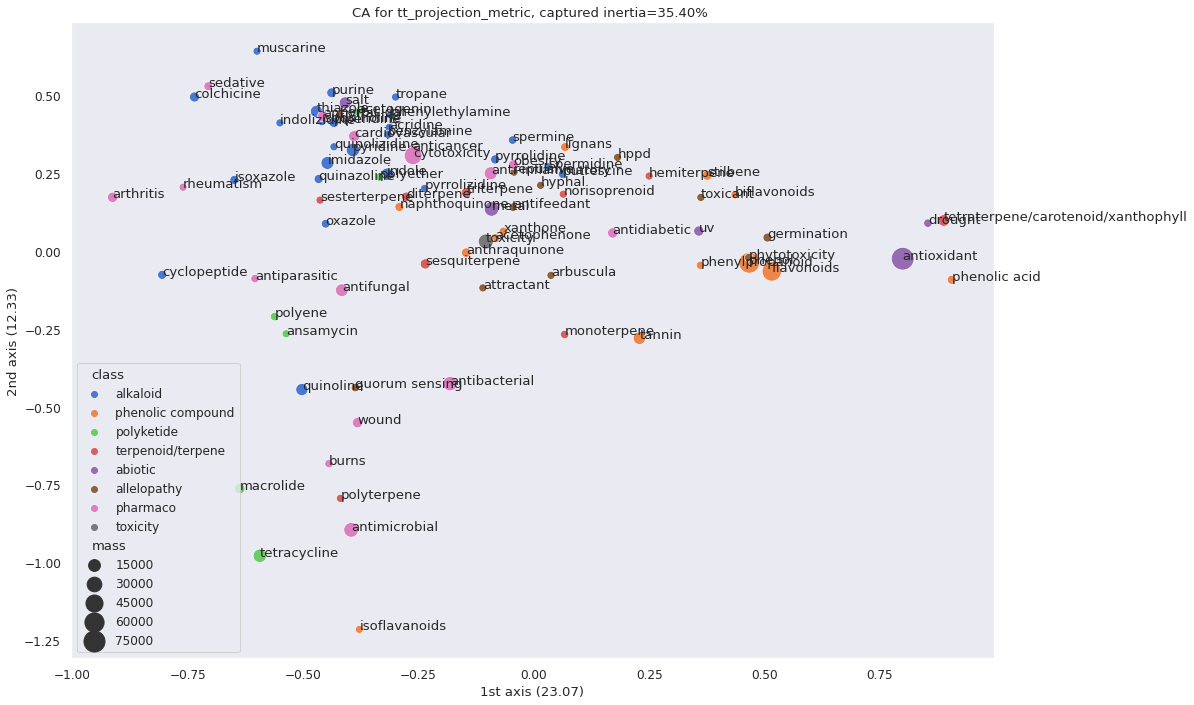

<Figure size 1190.88x842.4 with 1 Axes>

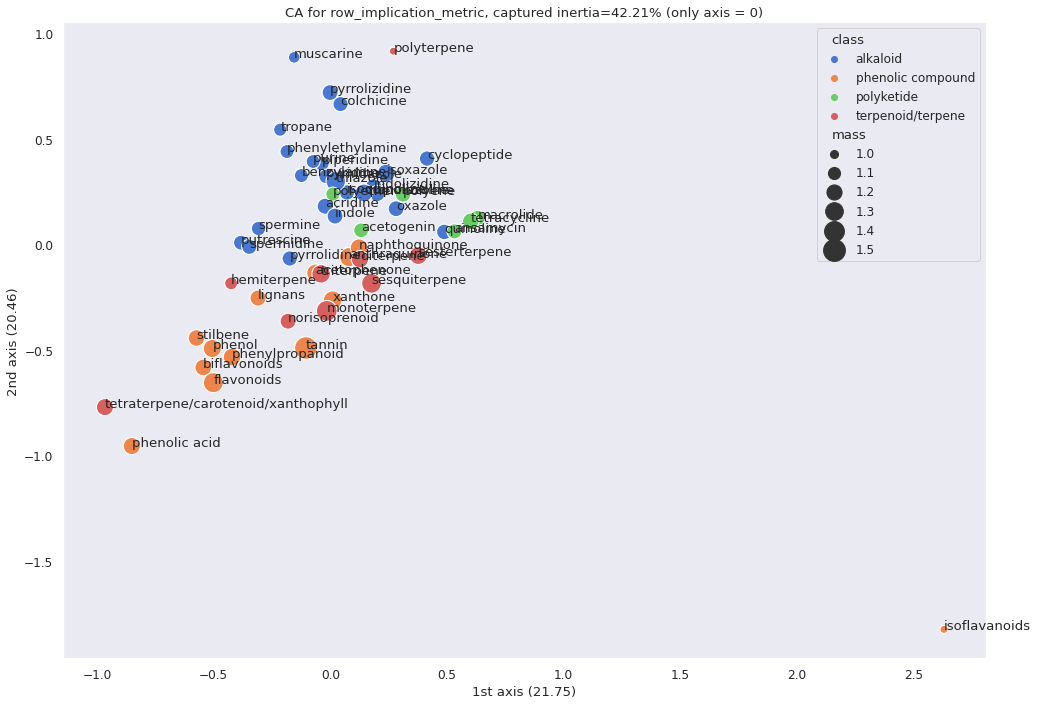

<Figure size 1190.88x842.4 with 1 Axes>

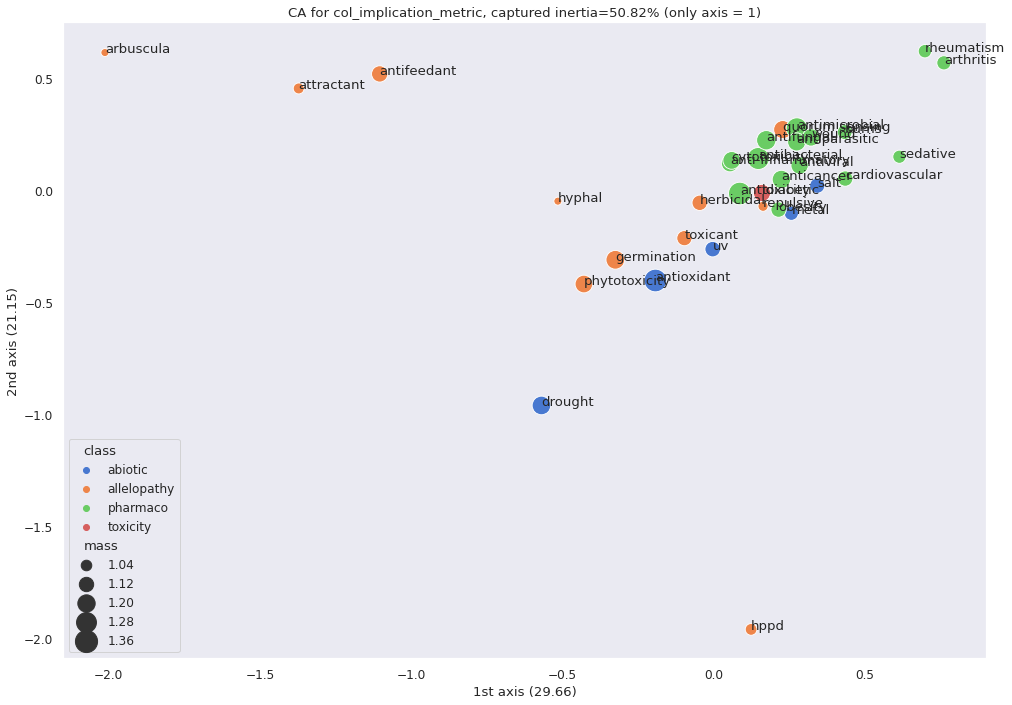

<Figure size 1190.88x842.4 with 1 Axes>

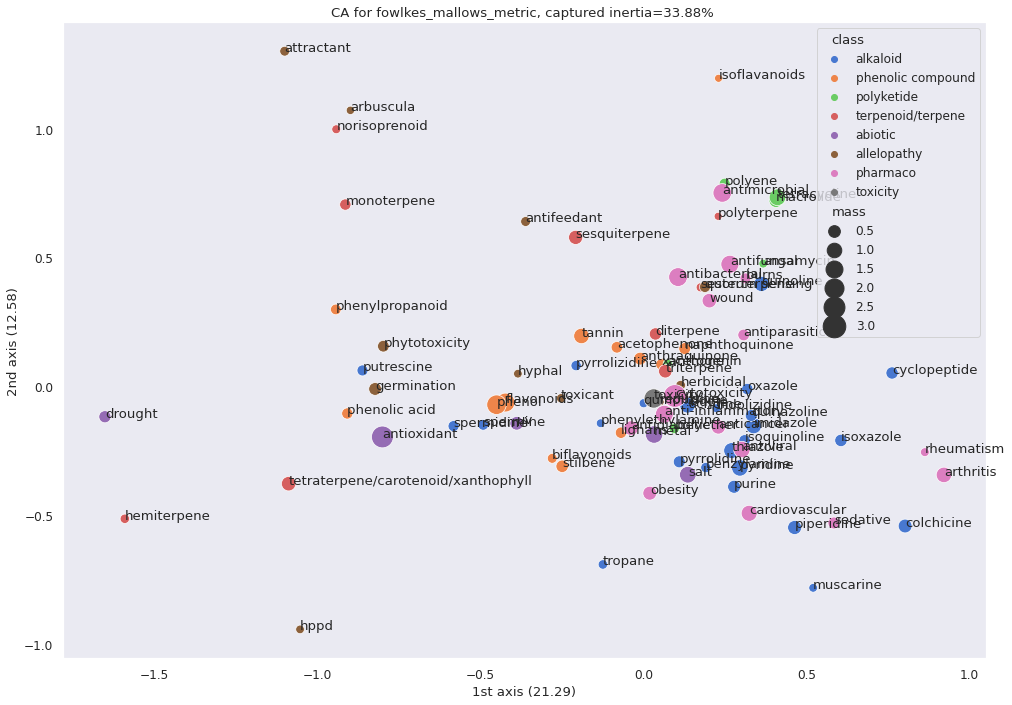

<Figure size 1190.88x842.4 with 1 Axes>

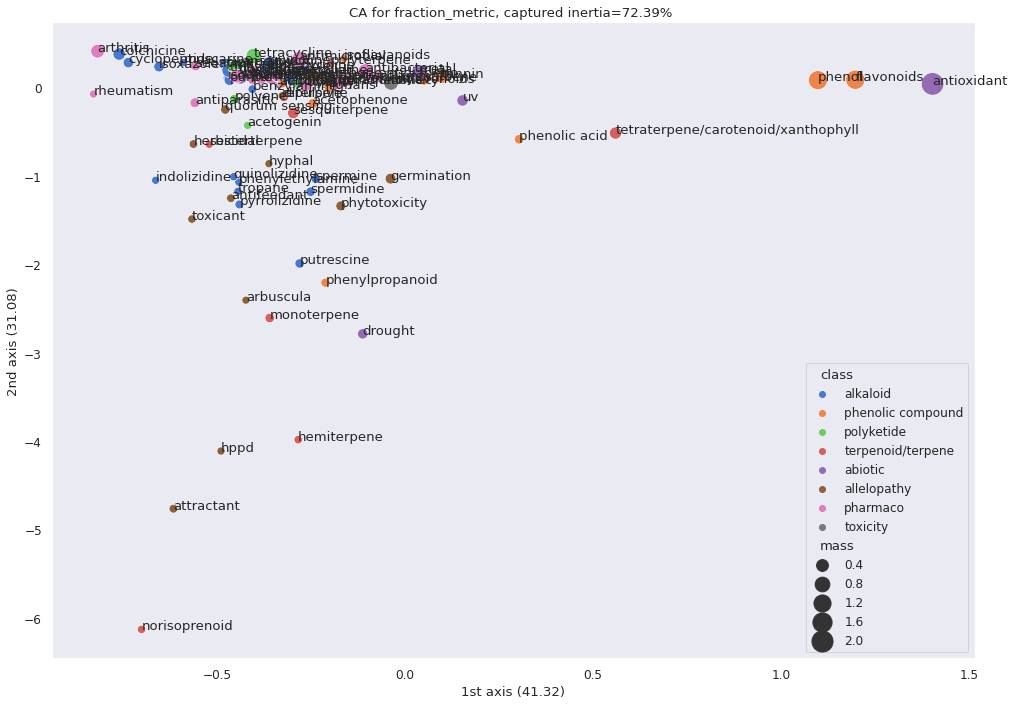

<Figure size 1190.88x842.4 with 1 Axes>

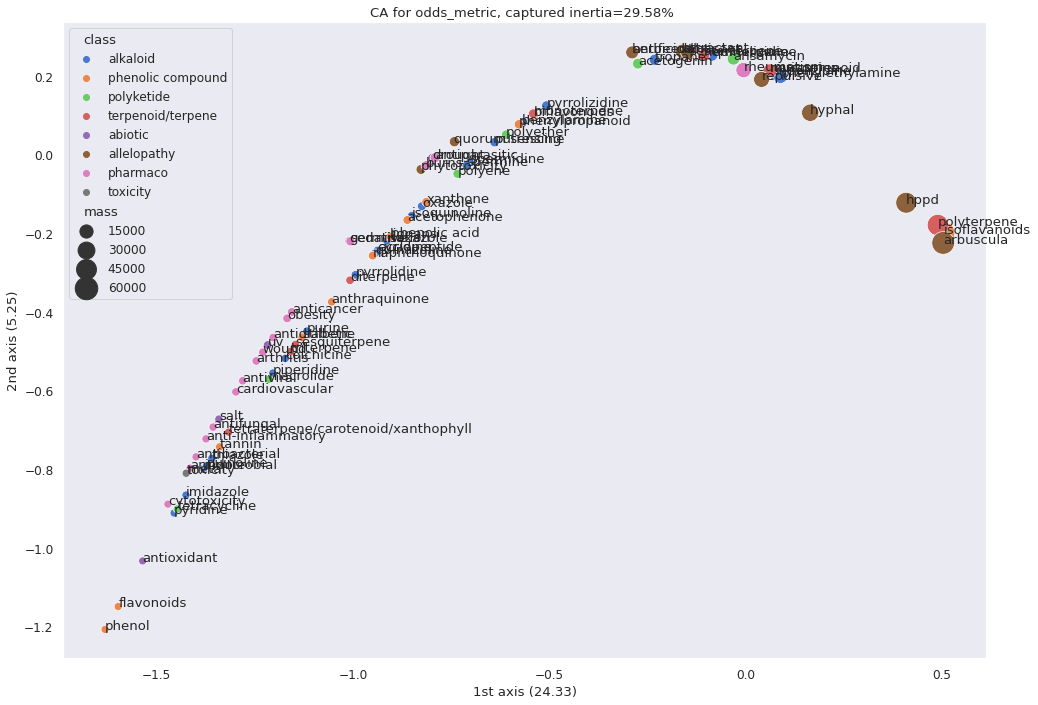

In [15]:
SHIFT = 0.00

for f_name, df in score_df.items():
    ca_res = correspondence_analysis(df)
    axis = None
    if f_name == "row_implication_metric":
        axis = 0
    if f_name == "col_implication_metric":
        axis = 1
    plot_ca = data_to_ca(df, ca_res.rows_coordinates, ca_res.cols_coordinates, axis=axis)

    ax = sns.scatterplot(data=plot_ca, x="1st axis", y="2nd axis", hue="class", size="mass", sizes=(64, 512))
    ax.set_title(
        f"CA for {f_name}, captured inertia={100*ca_res.inertias[:2].sum():.2f}% {f'(only {axis = })' if axis is not None else ''}"
    )
    ax.set_xlabel(f"1st axis ({100*ca_res.inertias[0]:.2f})")
    ax.set_ylabel(f"2nd axis ({100*ca_res.inertias[1]:.2f})")
    for index, row in plot_ca.iterrows():
        ax.annotate(index, (row["1st axis"] + SHIFT, row["2nd axis"] + SHIFT))
    plt.show()


In [16]:
def clean_implications(axis=0):
    if axis == 0:
        f_name = "row_implication_metric"
    elif axis == 1:
        f_name = "col_implication_metric"
    else:
        raise IndexError(f"no such axis {axis}")

    df = score_df[f_name].copy()
    df_support = (
        score_df["tt_projection_metric"]
        .melt(ignore_index=False, value_name="value")
        .reset_index()
        .drop(columns=["level_0", "variable_0"], axis=1)
        .rename(columns={"level_1": "compound", "variable_1": "activity"})
        .set_index(["compound", "activity"])
    )

    df.index = df.index.droplevel(0)
    df.columns = df.columns.droplevel(0)
    df = df.melt(ignore_index=False, value_name="%").reset_index()
    df.set_index(["index", "variable"], inplace=True)
    df.index.set_names(["compound", "activity"], inplace=True)
    df["mass"] = df_support["value"]
    # df["support"] = df_support["value"] / df["%"]
    df.sort_values(by="%", ascending=False, inplace=True)
    return df


# clean_implications(axis = 0)


In [17]:
NB_RULES_SHOWN = 15

print("Best implication rules : compound => activity")
clean_implications(0).head(NB_RULES_SHOWN)


Best implication rules : compound => activity


,,%,mass
compound,activity,,
isoflavanoids,antibacterial,1.000,2
phenolic acid,antioxidant,0.758,1879
acetogenin,cytotoxicity,0.720,229
tetraterpene/carotenoid/xanthophyll,antioxidant,0.717,7776
pyrrolizidine,toxicity,0.673,475
polyterpene,toxicity,0.667,2
polyene,antifungal,0.634,918
flavonoids,antioxidant,0.617,26670
sesterterpene,cytotoxicity,0.585,113


In [18]:
print("Best implication rule : activity => compound")
clean_implications(1).swaplevel().head(NB_RULES_SHOWN)

Best implication rule : activity => compound


% 
 mass 
 
 
 activity 
 compound 
 
 
 
 
 
 
 toxicant 
 phenol 
 0.587 
 71 
 
 
 arbuscula 
 sesquiterpene 
 0.455 
 5 
 
 
 antioxidant 
 phenol 
 0.445 
 28632 
 
 
 flavonoids 
 0.415 
 26670 
 
 
 uv 
 phenol 
 0.395 
 2662 
 
 
 repulsive 
 phenol 
 0.361 
 22 
 
 
 antidiabetic 
 flavonoids 
 0.339 
 2065 
 
 
 phytotoxicity 
 phenol 
 0.336 
 426 
 
 
 sedative 
 pyridine 
 0.324 
 813 
 
 
 drought 
 tetraterpene/carotenoid/xanthophyll 
 0.318 
 362 
 
 
 germination 
 phenol 
 0.317 
 802 
 
 
 antimicrobial 
 tetracycline 
 0.315 
 7095 
 
 
 hppd 
 tetraterpene/carotenoid/xanthophyll 
 0.312 
 5 
 
 
 salt 
 thiazole 
 0.310 
 4218 
 
 
 metal 
 phenol 
 0.309 
 8009

## Vizualizing data